<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”

**Author: Piotr Januszewski**

</center>



# Experiment tracking with ClearML

In this lab, you will yet again train a softmax regression model. However, this time, you will log the training diagnostics into the open-source experiment tracking tool called ClearML. You will learn how to analyse the results of many runs.

There are many experiments tracking tools on the market, most of them are paid (with free student accounts). Here, we are using ClearML, because it is an open-source tool. Alternatives worth knowing about are: Neptune, Weights&Biases, Comet.

The general setup is as follows:
* we are given the softmax regression model from the previous exercise and the same dataset,
* we log the matplotlib plots,
* we log the training metrics, hyper-parameters, and weights of the model in different configurations,
* we configure a leaderboard: sort, filter, and tag experiments,
* we compare the results using ClearML GUI,
* we download the metrics and plot the results manually in this jupyter notebook.

### Step 0. Let's start by setting up the environment.

1. [Sign up](https://app.community.clear.ml/) for free.
1. Set your ClearML credentials.
    1. Go to your [ClearML WebApp **Settings->Workspace**](https://app.clear.ml/settings/workspace-configuration).
    1. Under the **WORKSPACES** section, go to **App Credentials**, and click **+ Create new credentials**.  
       <img src="https://i.postimg.cc/43p69jSh/Screenshot-2021-10-12-at-09-48-31.png" width="400">
    1. Copy your credentials (**access_key** and **secret_key**) into the form below.  
       <img src="https://i.postimg.cc/tJFJSHFh/Screenshot-2021-10-12-at-09-56-21.png" width="400">
1. Run all the step's cells below (in order).  
  _You can ignore their content._

In [1]:
!pip install clearml
!pip install plotly==5.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [2]:
#@title Insert your own Credentials

from clearml import Task

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = 'NPLTQVPT3RX1OXYWXVEQ'#@param {type:"string"}
secret_key = 'FjxTCo19fLp4XfO4LHRdyYBhuL7Hv3BCbGDMRcjr4z9HuEMmX1'#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [4]:
# Imports and loads MNIST.

!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()
X = x_train[:4000]
y = y_train[:4000]

# Defines the model.

def softmax(z):
    z = np.exp(z)
    return z / np.sum(z, axis=1).reshape(-1,1)

def predict(weights, X):
    return softmax(X.dot(weights))

def compute_loss_and_gradients(weights, X, y, l2_reg):
    N = X.shape[0]
    prob = predict(weights, X)
    p = prob[np.arange(prob.shape[0]), y.argmax(axis=1)]
    loss = - np.log(p)

    grad = (1 / N) * np.dot(X.T,(prob - y)) + l2_reg * weights
    return loss.mean(), grad

--2023-10-15 08:53:39--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.168.48, 52.217.165.64, 16.182.107.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.168.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  54.2MB/s    in 0.2s    

2023-10-15 08:53:39 (54.2 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



### Step 1. Auto-log experiment

Log the training metrics of a softmax regression model for handwritten digits recognition. Follow instructions in the [First Steps: Auto-log Experiment](https://clear.ml/docs/latest/docs/getting_started/ds/ds_first_steps#auto-log-experiment) guide.

Hint:
<sub><sup><sub><sup><sub><sup>
ClearML will save everything you plot using matplotlib.
</sup></sub></sup></sub></sup></sub>

ClearML Task: created new task id=089a938db4444ce4bb85021504c3889f
2023-10-15 09:26:33,331 - clearml.Task - INFO - No repository found, storing script code instead


ClearML results page: https://app.clear.ml/projects/2b9a7538f56b4a138144226337867d79/experiments/089a938db4444ce4bb85021504c3889f/output/log
ClearML results page: https://app.clear.ml/projects/2b9a7538f56b4a138144226337867d79/experiments/089a938db4444ce4bb85021504c3889f/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


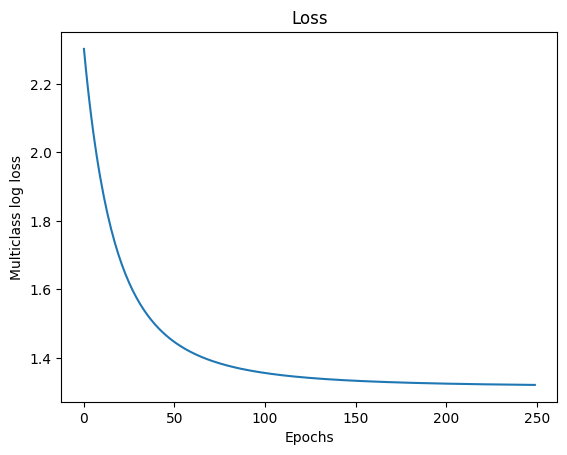

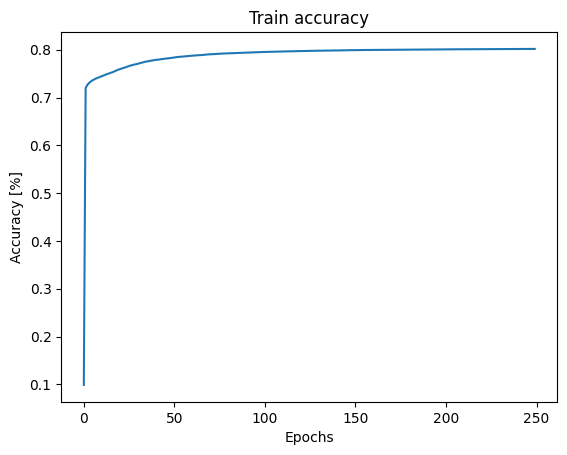

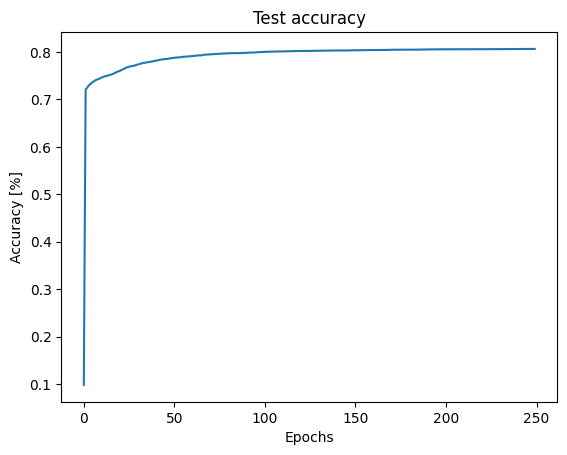

In [5]:
l2_reg = 0.5
n_epochs = 250
lr = 0.05
t = 0.99

############################
# TODO: Initialize a task. #
############################
# Set project_name='clearml_lab' and task_name='auto_log_experiment'.
task = Task.init(project_name='clearml_lab', task_name='auto_log_experiment')

# Initializes weights.
weights = np.zeros([X.shape[1], 10])

losses = []
train_accs = []
test_accs = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)

    # Calculates accuracies.
    train_accs.append(
        np.mean(predict(weights, x_train).argmax(axis=1) == y_train.argmax(axis=1)))
    test_accs.append(
        np.mean(predict(weights, x_test).argmax(axis=1) == y_test.argmax(axis=1)))

    weights -= lr * grad
    lr *= t

#####################################################################
# TODO: Log loss and accuracy (train and test) throughout training. #
#####################################################################
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Multiclass log loss')
plt.show()

plt.plot(train_accs)
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy [%]')
plt.show()

plt.plot(test_accs)
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy [%]')
plt.show()

task.close() # It's important to close the task before creating another one!

Now you can go to the ClearML dashboard and see the plots there. Follow:
1. Open `https://app.clear.ml/`.
1. _Log in._
1. Hit "Projects" in the left sidebar.
1. Pick your project.
1. Pick your experiment.
1. Hit "Results".
1. Hit "Plots".

_Fun fact:_ These curves seem pretty smooth. However, zoom in the test accuracy around the `[0.79, 0.81]` range on the y-axis and you'll see fluctuations in the performance. To do this, simply catch with your pointer a little above the accuracy plateau and drag it a little below it.

### Step 2. Metrics, hyper-parameters, and weights logging

Now we will log scalar metrics (instead of the whole plots like before), hyper-parameters, and model weights. See the [Next Steps](https://clear.ml/docs/latest/docs/getting_started/ds/ds_second_steps) guide.

In [14]:
config = {
    'l2_reg': 0,
    'n_epochs': 100,
    'lr': 0.1,
    't': 0.5
}

# Creates a task.
# We do not use `init` because we will not use auto-logging here.
task = Task.create(project_name='clearml_lab', task_name='manual_log_experiment')
# When task is created with `create`, we need to (but don't have to) manually mark it started/completed/etc.
task.mark_started()
logger = task.get_logger()

###################################
# TODO: Log the hyper-parameters. #
###################################
task.connect(config)

# Initializes weights.
weights = np.zeros([X.shape[1], 10])

lr_ = config['lr']
for i in range(config['n_epochs']):
    loss, grad = compute_loss_and_gradients(weights, X, y, config['l2_reg'])
    train_acc = np.mean(predict(weights, x_train).argmax(axis=1) == y_train.argmax(axis=1))
    test_acc = np.mean(predict(weights, x_test).argmax(axis=1) == y_test.argmax(axis=1))
    print(f'{i:3} | loss: {loss:.5f}, train_acc: {train_acc:.3f}, test_acc: {test_acc:.3f}')

    ###################################################
    # TODO: Log the loss and the train/test accuracy. #
    ###################################################
    logger.report_scalar(title='Loss', series='Train', iteration=i, value=loss)
    logger.report_scalar(title='Accuracy', series='Train', iteration=i, value=train_acc)
    logger.report_scalar(title='Accuracy', series='Test', iteration=i, value=test_acc)

    weights -= lr_ * grad
    lr_ *= config['t']

##########################################
# TODO: Save the weights as an artifact. #
##########################################
task.upload_artifact(name='weights', artifact_object=weights)

task.mark_completed()
task.close()

  0 | loss: 2.30259, train_acc: 0.099, test_acc: 0.098
  1 | loss: 2.19394, train_acc: 0.720, test_acc: 0.721
  2 | loss: 2.14359, train_acc: 0.728, test_acc: 0.728
  3 | loss: 2.11925, train_acc: 0.731, test_acc: 0.731
  4 | loss: 2.10728, train_acc: 0.732, test_acc: 0.732
  5 | loss: 2.10135, train_acc: 0.733, test_acc: 0.733
  6 | loss: 2.09840, train_acc: 0.733, test_acc: 0.733
  7 | loss: 2.09692, train_acc: 0.733, test_acc: 0.733
  8 | loss: 2.09618, train_acc: 0.733, test_acc: 0.733
  9 | loss: 2.09582, train_acc: 0.733, test_acc: 0.733
 10 | loss: 2.09563, train_acc: 0.733, test_acc: 0.734
 11 | loss: 2.09554, train_acc: 0.733, test_acc: 0.734
 12 | loss: 2.09549, train_acc: 0.733, test_acc: 0.734
 13 | loss: 2.09547, train_acc: 0.733, test_acc: 0.733
 14 | loss: 2.09546, train_acc: 0.733, test_acc: 0.733
 15 | loss: 2.09545, train_acc: 0.733, test_acc: 0.733
 16 | loss: 2.09545, train_acc: 0.733, test_acc: 0.733
 17 | loss: 2.09545, train_acc: 0.733, test_acc: 0.733
 18 | loss

You will find...
* ...the hyper-parameters under the "Configuration/General" tab.
* ...the metrics under the "Results/Scalars" tab.
* ...the trained weights under the "Artifacts" tab.

**Run the above code ~10 times with different hyper-parameters before the next step.** Use some extreme values too!

_Fun fact:_ ClearML will automagically save whole models (architecture, hyper-parameters, and weights) if you use popular frameworks like PyTorch, Tensorflow (Keras), Scikit-learn, ... See [this](https://clear.ml/docs/latest/docs/getting_started/ds/ds_second_steps/#models).

### Step 3. Creating leaderboards

Open the project in ClearML:
1. Open `https://app.clear.ml/`.
1. _Log in._
1. Hit "Projects" in the left sidebar.
1. Pick your project.

Configure a dashboard (experiment table) for your project:

* Present all metrics and hyper-parameters on the dashboard,
* Sort it by the test accuracy in descending order.
* Filter it by a hyper-parameter e.g. pick a subset of learning rates.
* Tag TOP 5 experiments 'top_5' (best in the colour of flames).

See the [Experiments Table](https://clear.ml/docs/latest/docs/webapp/webapp_exp_table/) guide.

_Fun fact:_ You can bookmark or share the URL of your experiment table, a specific experiment, or a comparison view, so you and your coworkers can see the same dashboard every time!

### Step 4. Comparing results

Prepare a compare view for your "top_5" tagged experiments where you can see the test accuracies of all five experiments.

See the [Selecting Experiments to Compare](https://clear.ml/docs/latest/docs/webapp/webapp_exp_comparing/#selecting-experiments-to-compare) guide and then the [Compare Scalar Series](https://clear.ml/docs/latest/docs/webapp/webapp_exp_comparing/#compare-scalar-series) guide.

### Step 5. Downloading results for local analysis

You can also download the results for local analysis (e.g. in this jupyter notebook). This is especially useful when you prepare plots for your publication. We plot the test accuracies of the "top_5" experiments together using Plotly.

See the [Querying \ Searching Tasks](https://clear.ml/docs/latest/docs/fundamentals/task#querying--searching-tasks) guide and the [Task](https://clear.ml/docs/latest/docs/references/sdk/task/) reference to find a function for downloading the scalars.

In [48]:
###########################################
# TODO: Query experiments tagged "top_5". #
###########################################
task_list = Task.get_tasks(
    project_name='clearml_lab',
    task_name='manual_log_experiment',
    tags=['top_5']
)

data = dict()
for task in task_list:
    ################################################
    # TODO: Get the reported test accuracy values. #
    ################################################
    metrics = task.get_all_reported_scalars()
    test_acc = metrics['Accuracy']['Test']['y']

    data[f'{task.name}.{task.id[:5]}'] = pd.Series(test_acc, index=np.arange(len(test_acc)))

fig = px.line(pd.DataFrame(data),
              labels={'index': 'Epochs',
                      'value': 'Accuracy [%]',
                      'variable': 'Experiment'},
              title='Test accuracy')
fig.show()

[0.098, 0.7208, 0.7258, 0.7305, 0.7337, 0.7368, 0.7394, 0.7416, 0.7427, 0.7446, 0.7466, 0.7478, 0.7493, 0.7499, 0.7512, 0.7524, 0.7535, 0.7557, 0.7575, 0.7591, 0.7602, 0.7628, 0.7641, 0.766, 0.7681, 0.769, 0.7699, 0.7707, 0.7713, 0.7728, 0.7738, 0.7748, 0.776, 0.7772, 0.7774, 0.7784, 0.7787, 0.7797, 0.7801, 0.7813, 0.7817, 0.7825, 0.7837, 0.7841, 0.7848, 0.7851, 0.7854, 0.7861, 0.7867, 0.7874, 0.7877, 0.7884, 0.7886, 0.7887, 0.7896, 0.7899, 0.7903, 0.7906, 0.7907, 0.7909, 0.7913, 0.792, 0.7922, 0.7928, 0.7928, 0.793, 0.7939, 0.7945, 0.7945, 0.7949, 0.7951, 0.7952, 0.7955, 0.7958, 0.7962, 0.7963, 0.7965, 0.7968, 0.797, 0.7969, 0.7974, 0.7975, 0.7975, 0.7975, 0.7976, 0.7976, 0.7977, 0.7978, 0.7979, 0.7982, 0.7984, 0.7987, 0.7989, 0.799, 0.7989, 0.7991, 0.7996, 0.7998, 0.8, 0.8002]
[0.098, 0.7208, 0.7258, 0.7305, 0.7337, 0.7368, 0.7394, 0.7416, 0.7427, 0.7446, 0.7466, 0.7478, 0.7493, 0.7499, 0.7512, 0.7524, 0.7535, 0.7557, 0.7575, 0.7591, 0.7602, 0.7628, 0.7641, 0.766, 0.7681, 0.769, 0.76

Below we report this Plotly plot to ClearML. ClearML reports Plotly plots in the ClearML Web UI > experiment details > RESULTS tab > PLOTS sub-tab (the same as in the Step 1. above).

In [49]:
task = Task.create(project_name='clearml_lab', task_name='compare_experiments')
task.get_logger().report_plotly(title='Accuracy', series='Test', iteration=0, figure=fig)
task.close()

### Step _Extra_. Play with the GUI for comparing results.

Look through the [Comparing Experiments](https://clear.ml/docs/latest/docs/webapp/webapp_exp_comparing/) guide. Especially interesting can be the [Parallel Coordinates Mode](https://clear.ml/docs/latest/docs/webapp/webapp_exp_comparing/#parallel-coordinates-mode) guide for finding the best hyper-parameters.